# Resnet50 for Blades?

In [1]:
from theano.sandbox import cuda

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


In [2]:
%matplotlib inline
import utils3
#reload(utils3)
from utils3 import *
from __future__ import division, print_function

Using Theano backend.


In [3]:
path = "/home/ubuntu/fast-ai/data/blades/"
model_path = '/home/ubuntu/fast-ai/data/blades/models/'
batch_size=64
os.path.exists(model_path)

True

In [4]:
import resnet50; reload(resnet50)
from resnet50 import Resnet50

In [5]:
resnet_model = Resnet50(include_top=False).model

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [6]:
resnet_model.output_shape

(None, 2048, 7, 7)

In [7]:
batches = get_batches(path+'train', shuffle=False, batch_size=batch_size)
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size*2)

Found 1243 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [8]:
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames, test_filenames) = get_classes(path)

Found 1243 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 1 classes.


In [9]:
trn_features = resnet_model.predict_generator(batches, batches.nb_sample)

In [10]:
val_features = resnet_model.predict_generator(val_batches, val_batches.nb_sample)

In [11]:
save_array(model_path + 'train_resnet50_features.bc', trn_features)
save_array(model_path + 'valid_resnet50_features.bc', val_features)

In [9]:
trn_features = load_array(model_path+'train_resnet50_features.bc')
val_features = load_array(model_path+'valid_resnet50_features.bc')

In [12]:
trn_features.shape

(1243, 2048, 7, 7)

## Global Average Pooling

In [13]:
def get_ap_layers(p):
    return [
        GlobalAveragePooling2D(input_shape=resnet_model.output_shape[1:]),
        Dropout(p),
        Dense(2, activation='softmax')
    ]

In [14]:
model = Sequential(get_ap_layers(.2))

In [15]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.fit(trn_features, trn_labels, nb_epoch=4, batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 1243 samples, validate on 100 samples
Epoch 1/4
1243/1243 [==============================] - 0s - loss: 0.6605 - acc: 0.6476 - val_loss: 0.6536 - val_acc: 0.6600
Epoch 2/4
1243/1243 [==============================] - 0s - loss: 0.4871 - acc: 0.7780 - val_loss: 0.4551 - val_acc: 0.8100

## Running on Test Set and Saving Results

In [27]:
import csv
test_batches = get_batches(path + 'test', shuffle=False)
wtr = csv.writer(open (path + 'results/' + 'filenames.csv', 'w'), delimiter=',', lineterminator='\n')
for x in test_batches.filenames : wtr.writerow ([x])

Found 100 images belonging to 1 classes.


In [28]:
test_features = resnet_model.predict_generator(test_batches, test_batches.nb_sample)
predicts = model.predict(test_features, batch_size=4)
predicts = [x[1] for x in predicts]
predicts = np.clip(predicts, 0.02, 0.98)
np.savetxt(path + 'results/' + 'predicts.csv', predicts, delimiter=',' , fmt='%1.5f')

In [29]:
%%bash -s "$path"
cd $1/results/
~/fast-ai/scripts/clean_data.sh filenames.csv predicts.csv

0AD0E0A5-3683-4BE7-B0EF-A43046B86900,0.07274
0BE5C2EA-03E0-45D5-A45F-508AA000B19E,0.21204
0C09E172-0808-4A33-A53C-69D973E64464,0.05227
0E389832-F4AB-4EC2-95E3-24FE4762EB05,0.22255
0EE2C8FD-F80F-4C02-96F3-8A2CAA0668EE,0.93668
1B191037-82EB-4E41-90F3-8F32AAF61834,0.74388
1DF3F5C8-2482-457A-98C2-FEE0012EBD2B,0.06415
1E098C48-23BE-43BF-8EB8-B9B96623178B,0.72284
1E35C282-A773-484B-B879-447F3BAC9841,0.14403
1EA984B8-5A4C-4FC0-8811-4D7ABC49A3FA,0.30386


In [17]:
def my_predict(imgs, resnet_model, addon_model):
    resnet_preds = resnet_model.predict(imgs)
    all_preds = addon_model.predict(resnet_preds)
    idxs = np.argmax(all_preds, axis=1)
    preds = [all_preds[i, idxs[i]] for i in range(len(idxs))]
    return np.array(preds), idxs

In [18]:
batches = get_batches(path+'test/', batch_size=4)

Found 100 images belonging to 1 classes.


array([ 0.9023,  0.6241,  0.6656,  0.9865], dtype=float32)

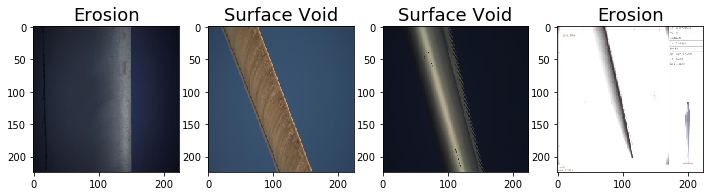

In [22]:
imgs,labels = next(batches)
preds, idxs = my_predict(imgs, resnet_model, model)
titles = map(lambda idx: ["Erosion", "Surface Void"][idx], idxs)
plots(imgs, titles=titles)
preds

## Resnet Large

In [5]:
resnet_model = Resnet50(include_top=False, size=(400,400)).model

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 400, 400)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [6]:
resnet_model.output_shape

(None, 2048, 13, 13)

In [7]:
batches = get_batches(path+'train', shuffle=False, batch_size=batch_size, target_size=(400,400))
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size*2, target_size=(400,400))
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames, test_filenames) = get_classes(path)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [8]:
trn_features = resnet_model.predict_generator(batches, batches.nb_sample)

In [9]:
val_features = resnet_model.predict_generator(val_batches, val_batches.nb_sample)

In [61]:
save_array(model_path + 'train_resnet50_lrg_features.bc', trn_features)
save_array(model_path + 'valid_resnet50_lrg_features.bc', val_features)

In [8]:
trn_features = load_array(model_path+'train_resnet50_lrg_features.bc')
val_features = load_array(model_path+'valid_resnet50_lrg_features.bc')

In [10]:
trn_features.shape

(23000, 2048, 13, 13)

In [13]:
model = Sequential(get_ap_layers(.01))

In [14]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.fit(trn_features, trn_labels, nb_epoch=3, batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 20s - loss: 0.0604 - acc: 0.9817 - val_loss: 0.0247 - val_acc: 0.9935

In [ ]:
import csv
test_batches = get_batches(path+'test', shuffle=False, batch_size=1, target_size=(400,400))
test_features = resnet_model.predict_generator(test_batches, batches.nb_sample)
#save_array(model_path + 'test_resnet50_lrg_features.bc', test_features)
wtr = csv.writer(open (path + 'results/' + 'filenames.csv', 'w'), delimiter=',', lineterminator='\n')
for x in test_batches.filenames : wtr.writerow ([x])
    
predicts = model.predict(test_features, batch_size=1)
predicts = [x[1] for x in predicts]
predicts = np.clip(predicts, 0.02, 0.98)
np.savetxt(path + 'results/' + 'predicts.csv', predicts, delimiter=',' , fmt='%1.5f')

In [ ]:
test_features = load_array(model_path+'test_resnet50_lrg_features.bc')